# ROC curves

In [1]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import roc_curve, roc_auc_score

from inference.utils import s_from_r, shuffle

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

## ROC curve function

In [2]:
def make_roc_curve(name, setting, f_sub_min=None, f_sub_max=None, beta_min=None, beta_max=None):
    print(name)
    llr0 = np.load("../data/results/llr_{}_prior.npy".format(name))
    llr1 = np.load("../data/results/llr_{}_shuffledprior.npy".format(name))
    
    if f_sub_min is not None or f_sub_max is not None or beta_min is not None or beta_max is not None:
        theta0 = np.load("../data/samples/theta_test_{}_prior.npy".format(setting))
        theta1 = np.load("../data/results/shuffled_theta_{}_shuffledprior.npy".format(name))
    
        cut0 = np.ones(llr0.shape[0], dtype=np.bool)
        cut1 = np.ones(llr1.shape[0], dtype=np.bool)
        
        if f_sub_min is not None:
            cut0 = np.logical_and(cut0, theta0[:, 0] >= f_sub_min)
            cut1 = np.logical_and(cut1, theta1[:, 0] >= f_sub_min)
            
        if f_sub_max is not None:
            cut0 = np.logical_and(cut0, theta0[:, 0] < f_sub_max)
            cut1 = np.logical_and(cut1, theta1[:, 0] < f_sub_max)
            
        if beta_min is not None:
            cut0 = np.logical_and(cut0, theta0[:, 1] >= beta_min)
            cut1 = np.logical_and(cut1, theta1[:, 1] >= beta_min)
            
        if beta_max is not None:
            cut0 = np.logical_and(cut0, theta0[:, 1] < beta_max)
            cut1 = np.logical_and(cut1, theta1[:, 1] < beta_max)
            
        llr0 = llr0[cut0]
        llr1 = llr1[cut1]
    
    y = np.concatenate((np.zeros(llr0.shape[0]), np.ones(llr1.shape[0])),0)
    llr = np.concatenate((llr0,llr1),0)
    s = s_from_r(np.exp(llr))
    
    fpr, tpr, _ = roc_curve(y, s)
    
    return fpr, tpr


In [3]:
def roc_auc(name, setting, f_sub_min=None, f_sub_max=None, beta_min=None, beta_max=None):
    llr0 = np.load("../data/results/llr_{}_prior.npy".format(name))
    llr1 = np.load("../data/results/llr_{}_shuffledprior.npy".format(name))
    
    if f_sub_min is not None or f_sub_max is not None or beta_min is not None or beta_max is not None:
        theta0 = np.load("../data/samples/theta_test_{}_prior.npy".format(setting))
        theta1 = np.load("../data/results/shuffled_theta_{}_shuffledprior.npy".format(name))
    
        cut0 = np.ones(llr0.shape[0], dtype=np.bool)
        cut1 = np.ones(llr1.shape[0], dtype=np.bool)
        
        if f_sub_min is not None:
            cut0 = np.logical_and(cut0, theta0[:, 0] >= f_sub_min)
            cut1 = np.logical_and(cut1, theta1[:, 0] >= f_sub_min)
            
        if f_sub_max is not None:
            cut0 = np.logical_and(cut0, theta0[:, 0] < f_sub_max)
            cut1 = np.logical_and(cut1, theta1[:, 0] < f_sub_max)
            
        if beta_min is not None:
            cut0 = np.logical_and(cut0, theta0[:, 1] >= beta_min)
            cut1 = np.logical_and(cut1, theta1[:, 1] >= beta_min)
            
        if beta_max is not None:
            cut0 = np.logical_and(cut0, theta0[:, 1] < beta_max)
            cut1 = np.logical_and(cut1, theta1[:, 1] < beta_max)
            
        llr0 = llr0[cut0]
        llr1 = llr1[cut1]
    
    y = np.concatenate((np.zeros(llr0.shape[0]), np.ones(llr1.shape[0])),0)
    llr = np.concatenate((llr0,llr1),0)
    s = s_from_r(np.exp(llr))
    
    return roc_auc_score(y, s)


## Data for overall ROC curve

In [4]:
filenames = [
    "carl_fix",
    "alice_fix",
    "alices_fix",
    "carl_mass",
    "alice_mass",
    "alices_mass",
]
settings = ["fix"] * 3 + ["mass"] * 3 + ["align"] * 3 + ["full"] * 6
labels = [
    "CARL (fix)",
    "ALICE (fix)",
    "ALICES (fix)",
    "CARL (mass)",
    "ALICE (mass)",
    "ALICES (mass)",
    "CARL (align)",
    "ALICE (align)",
    "ALICES (align)",
    "CARL (full)",
    "ALICE (full)",
    "ALICES (full)",
    "CARL (full-aux)",
    "ALICE (full-aux)",
    "ALICES (full-aux)",
]
colors = ["C0"] * 3 + ["C1"] * 3 + ["C2"] * 3 + ["C3"] * 3 + ["C4"] * 3
lss = ["-", "--", "-."]*5

In [5]:
rocs = []
roc_aucs = []

for filename, setting in zip(filenames, settings):
    rocs.append(make_roc_curve(filename, setting))
    roc_aucs.append(roc_auc(filename, setting))

carl_fix
alice_fix
alices_fix
carl_mass
alice_mass
alices_mass


## Plot overall ROC curve

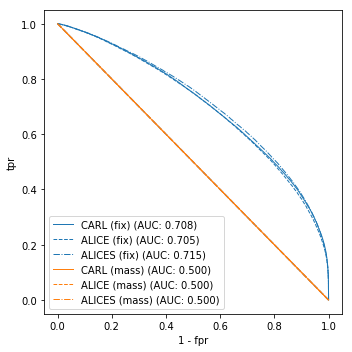

In [7]:
fig = plt.figure(figsize=(5,5))

plt.plot([0.,1.], [1.,0.], ls="--", c="0.5")
for roc, auc, label, color, ls in zip(rocs, roc_aucs, labels, colors, lss):
    plt.plot(1. - roc[0], roc[1], c=color, lw=1., ls=ls, label=label + " (AUC: {:.3f})".format(auc))

plt.legend()

plt.xlabel("1 - fpr")
plt.ylabel("tpr")

plt.tight_layout()
plt.savefig("../figures/roc.pdf")


## ROC curves for different parameter regions

In [12]:
filenames = 9*["alice"]
f_sub_min = [None, None, None, 100., 100., 100., 200., 200., 200.]
f_sub_max = [100., 100., 100., 200., 200., 200., None, None, None]
beta_min = 3*[None, -2.4, -1.7]
beta_max = 3*[-2.4, -1.7, None]
colors = ["C{}".format(i) for i in range(9)]
lss = [":", ":", ":", "--", "--", "--", "-", "-", "-"]


In [13]:
labels = []
rocs = []
roc_aucs = []

for filename, nmin, nmax, bmin, bmax in zip(filenames, f_sub_min, f_sub_max, beta_min, beta_max):
    rocs.append(make_roc_curve(filename, nmin, nmax, bmin, bmax))
    roc_aucs.append(roc_auc(filename, nmin, nmax, bmin, bmax))

    nmin = 10. if nmin is None else nmin
    nmax = 400. if nmax is None else nmax
    bmin = -3. if bmin is None else bmin
    bmax = -1.1 if bmax is None else bmax
    labels.append(r"${:.0f} < n_{{calib}} < {:.0f}$, ${:.1f} < \beta < {:.1f}$".format(nmin, nmax, bmin, bmax))

alice
alice
alice
alice
alice
alice
alice
alice
alice


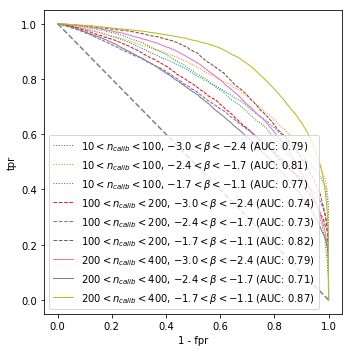

In [14]:
fig = plt.figure(figsize=(5,5))

plt.plot([0.,1.], [1.,0.], ls="--", c="0.5")
for roc, auc, label, color, ls in zip(rocs, roc_aucs, labels, colors, lss):
    plt.plot(1. - roc[0], roc[1], c=color, lw=1., ls=ls, label=label + " (AUC: {:.2f})".format(auc))

plt.legend()

plt.xlabel("1 - fpr")
plt.ylabel("tpr")

plt.tight_layout()
plt.savefig("../figures/roc_by_parameter_region.pdf")


## ROC between different parameter points

In [44]:
def roc_curve_between_regions(
    name,
    f_sub_min0=None, f_sub_max0=None, beta_min0=None, beta_max0=None,
    f_sub_min1=None, f_sub_max1=None, beta_min1=None, beta_max1=None,
):
    llr = np.load("../data/results/llr_{}_prior.npy".format(name))
    theta = np.load("../data/samples/theta_test_prior.npy")
    
    cut0 = np.ones(llr.shape[0], dtype=np.bool)
    if f_sub_min0 is not None:
        cut0 = np.logical_and(cut0, theta[:, 0] >= f_sub_min0)
    if f_sub_max0 is not None:
        cut0 = np.logical_and(cut0, theta[:, 0] < f_sub_max0)
    if beta_min0 is not None:
        cut0 = np.logical_and(cut0, theta[:, 1] >= beta_min0)
    if beta_max0 is not None:
        cut0 = np.logical_and(cut0, theta[:, 1] < beta_max0)
    llr0 = llr[cut0]
    
    cut1 = np.ones(llr.shape[0], dtype=np.bool)
    if f_sub_min1 is not None:
        cut1 = np.logical_and(cut1, theta[:, 0] >= f_sub_min1)
    if f_sub_max1 is not None:
        cut1 = np.logical_and(cut1, theta[:, 0] < f_sub_max1)
    if beta_min1 is not None:
        cut1 = np.logical_and(cut1, theta[:, 1] >= beta_min1)
    if beta_max1 is not None:
        cut1 = np.logical_and(cut1, theta[:, 1] < beta_max1)
    llr1 = llr[cut1]
    
    y = np.concatenate((np.zeros(llr0.shape[0]), np.ones(llr1.shape[0])),0)
    llr = np.concatenate((llr0, llr1),0)
    s = s_from_r(np.exp(llr))
    
    fpr, tpr, _ = roc_curve(y, s)
    
    return fpr, tpr


In [45]:
def roc_auc_between_regions(
    name,
    f_sub_min0=None, f_sub_max0=None, beta_min0=None, beta_max0=None,
    f_sub_min1=None, f_sub_max1=None, beta_min1=None, beta_max1=None,
):
    llr = np.load("../data/results/llr_{}_prior.npy".format(name))
    theta = np.load("../data/samples/theta_test_prior.npy")
    
    cut0 = np.ones(llr.shape[0], dtype=np.bool)
    if f_sub_min0 is not None:
        cut0 = np.logical_and(cut0, theta[:, 0] >= f_sub_min0)
    if f_sub_max0 is not None:
        cut0 = np.logical_and(cut0, theta[:, 0] < f_sub_max0)
    if beta_min0 is not None:
        cut0 = np.logical_and(cut0, theta[:, 1] >= beta_min0)
    if beta_max0 is not None:
        cut0 = np.logical_and(cut0, theta[:, 1] < beta_max0)
    llr0 = llr[cut0]
    
    cut1 = np.ones(llr.shape[0], dtype=np.bool)
    if f_sub_min1 is not None:
        cut1 = np.logical_and(cut1, theta[:, 0] >= f_sub_min1)
    if f_sub_max1 is not None:
        cut1 = np.logical_and(cut1, theta[:, 0] < f_sub_max1)
    if beta_min1 is not None:
        cut1 = np.logical_and(cut1, theta[:, 1] >= beta_min1)
    if beta_max1 is not None:
        cut1 = np.logical_and(cut1, theta[:, 1] < beta_max1)
    llr1 = llr[cut1]
    
    print(llr0, llr1)
    
    y = np.concatenate((np.zeros(llr0.shape[0]), np.ones(llr1.shape[0])),0)
    llr = np.concatenate((llr0, llr1),0)
    s = s_from_r(np.exp(llr))
    
    return roc_auc_score(y, s)


In [46]:
roc = roc_curve_between_regions("alice", None, 50., None, -2.5, None, 50., -1.6, None)
auc = roc_auc_between_regions("alice", None, 50., None, -2.5, None, 50., -1.6, None)


[ 1.1647954   1.5841193   1.0079122  ...  0.89167726 -0.2035547
  0.7015494 ] [-0.33796763  0.6207841   0.8595598  ...  1.7249944   1.082964
  0.31725305]


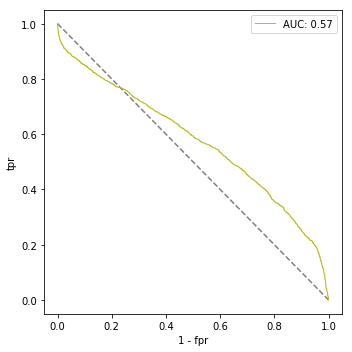

In [47]:
fig = plt.figure(figsize=(5,5))

plt.plot([0.,1.], [1.,0.], ls="--", c="0.5")
plt.plot(1. - roc[0], roc[1], c=color, lw=1., ls=ls, label="AUC: {:.2f}".format(auc))

plt.legend()

plt.xlabel("1 - fpr")
plt.ylabel("tpr")

plt.tight_layout()
plt.savefig("../figures/roc_between_parameter_region.pdf")

